# MRtrix3Tissue

**Authors:** Thuy Dao, Monika Doerig

**Citation:** 

__Software tools__:
- [MRtrix3Tissue](https://3tissue.github.io/about.html), a fork of MRtrix3 ([Tournier et al. 2019](https://www.sciencedirect.com/science/article/abs/pii/S1053811919307281)).

__Dataset from OpenNeuro:__ BTC_postop
- Hannelore Aerts and Daniele Marinazzo (2022). BTC_postop. OpenNeuro. [Dataset] doi: [doi:10.18112/openneuro.ds002080.v4.0.0](https://openneuro.org/datasets/ds002080/versions/4.0.0)

## Setup Neurodesk

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC 7742 64-Core Processor


In [ ]:
%%capture
!pip install nibabel numpy

In [28]:
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile

## Introduction

In [1]:
# load fmriprep
import module
import os
await module.load('mrtrix3tissue/5.2.8')
await module.list()

['mrtrix3tissue/5.2.8']

## Data preparation

In [4]:
# download data
!datalad install https://github.com/OpenNeuroDatasets/ds002080.git
!cd ds002080 && datalad get sub-CON02

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/20.6k [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/12.7k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/22.6k [00:00<?, ? Objects/s]
Receiving:   9%|█▊                  | 2.03k/22.6k [00:00<00:01, 18.3k Objects/s]
Receiving:  31%|██████▏             | 6.99k/22.6k [00:00<00:00, 35.3k Objects/s]
Receiving:  49%|█████████▊          | 11.1k/22.6k [00:00<00:00, 37.2k Objects/s]
Receiving:  83%|████████████████▌   | 18.7k/22.6k [00:00<00:00, 52.1k Objects/s]
                                                                                
Resolving:   0%

### Convert to .mif file
Once data is downloaded, it is recommended to import and store it as .mif file(s), the so-called “MRtrix Image Format”.

`mrconvert` is the tool to convert between all sorts of image formats (or extract parts of images or change properties) and enables you to read from e.g. DICOM folders or NIfTI (.nii) images and store an image as a .mif file.

If your diffusion MRI data comes as a NIfTI (.nii) image instead, the gradient orientations and b-values will typically be stored in 2 separate files (a “bvecs” and “bvals” file).

In [ ]:
%%bash
mrconvert ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz AP.mif -fslgrad ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bvec ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bval
mrconvert ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.nii.gz PA.mif
mrconvert PA.mif -fslgrad ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.bvec ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.bval - | mrmath - mean mean_b0_PA.mif -axis 3

mrconvert: [100%] uncompressing image "ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz"
mrconvert: [100%] copying from "ds002080/s...es-postop_acq-AP_dwi.nii.gz" to "AP.mif"copying from "ds002080/s...es-postop_acq-AP_dwi.nii.gz" to "AP.mif"... 
mrconvert: [100%] uncompressing image "ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.nii.gz"
mrconvert: [100%] copying from "ds002080/s...es-postop_acq-PA_dwi.nii.gz" to "PA.mif"
mrconvert: [100%] copying from "PA.mif" to "/tmp/mrtrix-tmp-UmjVdc.mif"
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-UmjVdc.mif"
mrmath: [100%] computing mean along axis 3...


## Preprocessing
The following are common preprocessing steps done with MRtrix.

### Denoising and Gibbs ringing removal (“unringing”)
The first preprocessing step is denoise the data by using `dwidenoise` command. This requires an input and an output argument, and you also have the option to output the noise map with the `-noise` option.

The next step is to run `mrdegibbs`, which removes Gibbs’ ringing artifacts from the data. 

In [ ]:
%%bash
dwidenoise AP.mif dwi_denoised.mif -noise noise.mif
mrdegibbs dwi_denoised.mif dwi_denoised_unringed.mif

dwidenoise: [100%] preloading data for "AP.mif"
dwidenoise: [ 13%] running MP-PCA denoising... : [  0%] running MP-PCA denoising... : [  1%] running MP-PCA denoising... : [  1%] running MP-PCA denoising... : [  1%] running MP-PCA denoising... : [  2%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... [  3%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... : [  3%] running MP-PCA denoising... : [  4%] running MP-PCA denoising... : [  5%] running MP-PCA denoising... ?7lg... : [  5%] running MP-PCA denoising... : [  5%] running MP-PCA denoising... : [  5%] running MP-PCA denoising... : [  6%] running MP-PCA denoising... : [  6%] running MP-PCA denoising... : [  7%] running MP-PCA denoising... : [  7%] running MP-PCA denoising... g... : [  7%] running MP-PCA denoising... : [  7%] running MP-PCA denoising...  MP-PCA denoising... g... ?7l MP-PCA denois

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwidenoise: [ 26%] running MP-PCA denoising... ?7l: [ 16%] running MP-PCA denoising... : [ 16%] running MP-PCA denoising... g... ?7lg... : [ 16%] running MP-PCA denoising... : [ 16%] running MP-PCA denoising... g... : [ 16%] running MP-PCA denoising... : [ 17%] running MP-PCA denoising... g... g... : [ 17%] running MP-PCA denoising... : [ 18%] running MP-PCA denoising... g... : [ 19%] running MP-PCA denoising...  MP-PCA denoising... : [ 19%] running MP-PCA denoising... : [ 19%] running MP-PCA denoising...  MP-PCA denoising... : [ 20%] running MP-PCA denoising... : [ 20%] running MP-PCA denoising... : [ 20%] running MP-PCA denoising...  MP-PCA denoising... : [ 20%] running MP-PCA denoising... : [ 21%] running MP-PCA denoising... : [ 22%] running MP-PCA denoising...  MP-PCA denoising... : [ 22%] running MP-PCA denoising... ?7lg... : [ 22%] running MP-PCA denoising... : [ 23%] running MP-PCA denoising... : [ 23%] running MP-PCA denoising... : [ 23%] running MP-PCA denoising... : [ 24%] ru

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwidenoise: [ 27%] running MP-PCA denoising... : [ 27%] running MP-PCA denoising... 27%] running MP-PCA denoising... : [ 27%] running MP-PCA denoising... : [ 27%] running MP-PCA denoising...  MP-PCA denoising... [ 27%] running MP-PCA denoising... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwidenoise: [100%] running MP-PCA denoisingP-PCA denoising... g... ?7l MP-PCA denoising... : [ 29%] running MP-PCA denoising...  MP-PCA denoising... : [ 29%] running MP-PCA denoising... P-PCA denoising... : [ 30%] running MP-PCA denoising... : [ 30%] running MP-PCA denoising... : [ 30%] running MP-PCA denoising...  MP-PCA denoising... : [ 31%] running MP-PCA denoising... : [ 32%] running MP-PCA denoising... : [ 32%] running MP-PCA denoising... : [ 32%] running MP-PCA denoising... P-PCA denoising...  MP-PCA denoising...  MP-PCA denoising... g... : [ 33%] running MP-PCA denoising... 33%] running MP-PCA denoising... : [ 33%] running MP-PCA denoising... : [ 33%] running MP-PCA denoising... : [ 33%] running MP-PCA denoising... lg... ?7l: [ 33%] running MP-PCA denoising... g... : [ 33%] running MP-PCA denoising... ?7lPCA denoising... ?7lg...  ?7l: [ 34%] running MP-PCA denoising...  MP-PCA denoising... : [ 34%] running MP-PCA denoising...  MP-PCA denoising... .. .. : [ 34%] running MP-PCA de

Next, we extract the b-values from the primary phase-encoded image using `dwiextract`.

If you have also scanned a pair of reverse phase-encoded b=0 images, you can correct for susceptibility-induced EPI distortions by concatenating the reverse phase-encoded b=0 images using `mrcat` to create a new image `b0_pair.mif`

In [4]:
!dwiextract dwi_denoised.mif - -bzero | mrmath - mean mean_b0_AP.mif -axis 3
!mrcat mean_b0_AP.mif mean_b0_PA.mif -axis 3 b0_pair.mif

dwiextract: [100%] extracting volumes
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-6C47Cy.mif"
mrmath: [100%] computing mean along axis 3...
mrcat: [100%] concatenating "mean_b0_AP.mif"
mrcat: [100%] concatenating "mean_b0_PA.mif"


### Motion and distortion correction

Motion and distortion correction are performed by the `dwifslpreproc` command, most of the heavy lifting is done automatically by FSL’s `topup` and `eddy` tools.

`-pe_dir` option is used to tell dwifslpreproc the phase-encoding direction of the scan.

` -se_epi` is an additional image series consisting of spin-echo EPI images used by `topup` for estimating the inhomogeneity field

`-eddy_options` is an additional command-line options to the `eddy`

In [5]:
!dwifslpreproc dwi_denoised_unringed.mif dwi_denoised_unringed_preproc.mif -pe_dir AP -rpe_pair -se_epi b0_pair.mif  -eddy_options " --slm=linear --data_is_shelled"

dwifslpreproc: 
dwifslpreproc: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwifslpreproc: 
dwifslpreproc: Generated scratch directory: /data/books/diffusion_imaging/dwifslpreproc-tmp-BQFUSF/
Command:  mrconvert /data/books/diffusion_imaging/dwi_denoised_unringed.mif /data/books/diffusion_imaging/dwifslpreproc-tmp-BQFUSF/dwi.mif -json_export /data/books/diffusion_imaging/dwifslpreproc-tmp-BQFUSF/dwi.json
Command:  mrconvert /data/books/diffusion_imaging/b0_pair.mif /data/books/diffusion_imaging/dwifslpreproc-tmp-BQFUSF/se_epi.mif
dwifslpreproc: Changing to scratch directory (/data/books/diffusion_imaging/dwifslpreproc-tmp-BQFUSF/)
dwifslpreproc: Total readout time not provided at command-line; assuming sane default of 0.1
Command:  mrinfo dwi.mif -export_grad_mrtrix grad.b
Command:  mrconvert se_epi.mif topup_in.nii -import_p

#### Bias field correction
You can correct for bias fields at this point in the pipeline with the `dwibiascorrect ants` command

In [15]:
!dwibiascorrect ants dwi_denoised_unringed_preproc.mif dwi_denoised_unringed_preproc_unbiased.mif

dwibiascorrect: 
dwibiascorrect: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwibiascorrect: 
dwibiascorrect: Generated scratch directory: /data/books/diffusion_imaging/dwibiascorrect-tmp-85JIKY/
Command:  mrconvert /data/books/diffusion_imaging/dwi_denoised_unringed_preproc.mif /data/books/diffusion_imaging/dwibiascorrect-tmp-85JIKY/in.mif
dwibiascorrect: Changing to scratch directory (/data/books/diffusion_imaging/dwibiascorrect-tmp-85JIKY/)
Command:  dwi2mask in.mif mask.mif
Command:  dwiextract in.mif - -bzero | mrmath - mean mean_bzero.mif -axis 3
Command:  mrconvert mean_bzero.mif mean_bzero.nii -strides +1,+2,+3
Command:  mrconvert mask.mif mask.nii -strides +1,+2,+3
Command:  N4BiasFieldCorrection -d 3 -i mean_bzero.nii -w mask.nii -o [corrected.nii,init_bias.nii] -s 4 -b [100,3] -c [1000,0.0]
Command:  mrcalc mean_b

### Brain mask estimation
A brain mask can be estimated automatically from the diffusion MRI data using `dwi2mask` as follows:

In [16]:
!dwi2mask dwi_denoised_unringed_preproc_unbiased.mif dwi_mask.mif

dwi2mask: [ 48%] preloading data for "dwi_denoised_unringed_preproc_unbiased.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [100%] preloading data for "dwi_denoised_unringed_preproc_unbiased.mif"
dwi2mask: [100%] finding min/max of "mean b=0 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=700 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=1200 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=2800 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [done] computing dwi brain mask
dwi2mask: [done] applying mask cleaning filter


## Decomposition
### 3-tissue response function estimation
An method to obtain 3-tissue response functions representing single-fibre white matter (WM), grey matter (GM) and CSF from the data itself, is available as the so-called `dwi2response dhollander` command from `MRtrix3Tissue` package.

In [17]:
!dwi2response dhollander dwi_denoised_unringed_preproc_unbiased.mif response_wm.txt response_gm.txt response_csf.txt

dwi2response: 
dwi2response: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
dwi2response: 
dwi2response: Generated scratch directory: /data/books/diffusion_imaging/dwi2response-tmp-34ZKBV/
dwi2response: Importing DWI data (/data/books/diffusion_imaging/dwi_denoised_unringed_preproc_unbiased.mif)...
dwi2response: Changing to scratch directory (/data/books/diffusion_imaging/dwi2response-tmp-34ZKBV/)
dwi2response: Computing brain mask (dwi2mask)...
dwi2response: -------
dwi2response: 4 unique b-value(s) detected: 0,700,1200,2800 with 6,16,30,50 volumes
dwi2response: -------
dwi2response: Preparation:
dwi2response: * Eroding brain mask by 3 pass(es)...
dwi2response:   [ mask: 96513 -> 69367 ]
dwi2response: * Computing signal decay metric (SDM):
dwi2response:  * b=0...
dwi2response:  * b=700...
dwi2response:  * b=1200...
dwi2response:  * b=2800...
dwi2response: * Removing er

### Upsampling

Upsampling your preprocessed diffusion MRI data before the 3-tissue constrained spherical deconvolution (3-tissue CSD) step to get a higher quality result. Upsampling is useful if you’re after a higher quality visualisation, which reveals finer details using `mrgrid`.

In [20]:
!mrgrid dwi_denoised_unringed_preproc_unbiased.mif regrid dwi_denoised_unringed_preproc_unbiased_upsampled.mif -voxel 1.5

mrgrid: [100%] reslicing "dwi_denoised_unringed_preproc_unbiased.mif"eproc_unbiased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... [0Kbiased.mif"... biased.mif"... 52%] reslicing "dwi_denoised_unringed_preproc_unbiased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... ised_unringed_preproc_unbiased.mif"... biased.mif"... biased.mif"... eproc_unbiased.mif"... biased.mif"... biased.mif"... biased.mif"... ised_unringed_preproc_unbiased.mif"... biased.mif"... biased.mif"... biased.mif"... 77%] reslicing "dwi_denoised_unringed_preproc_unbiased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... biased.mif"... 95%] reslicing "dwi_denoised_unringed_preproc_unbiased.mif"... licing "dwi_denoised_unringed_

After upsampling the image, you need to regrid the brain mask to the exact same voxel grid as the image via the `-template` option to `mrgrid`. If the regridding is effectively upsampling, you can avoid jagged edges around masks by performing linear interpolation `-interp linear`. Then a median filter the result using the `maskfilter` command. To perform all of this at once (without storing an intermediate image), you an directly “pipe” the output of mrgrid into the input of maskfilter, by replacing the output in the one command and the input in the other command by a dash (“-”), and typing a “pipe” (“|”) between both commands.

In [21]:
!mrgrid dwi_mask.mif regrid - -template dwi_denoised_unringed_preproc_unbiased_upsampled.mif -interp linear -datatype bit | maskfilter - median dwi_mask_upsampled.mif

mrgrid: [100%] reslicing "dwi_mask.mif"
maskfilter: [100%] applying median filter to image -


### 3-tissue CSD modelling
Your data is now ready for 3-tissue CSD modelling with the previously obtained 3-tissue response functions, which will result in modelling the diffusion MRI data using WM-like (FOD), GM-like and CSF-like compartments. There are 2 different methods (or algorithms) available to perform 3-tissue CSD. The choice between both depends on what (part of your) data you intend to perform 3-tissue CSD modelling for.

If you want to perform 3-tissue CSD modelling for multi-shell data, this can be achieved using the multi-shell multi-tissue CSD (MSMT-CSD) method or algorithm, as follows:

In [22]:
!dwi2fod msmt_csd dwi_denoised_unringed_preproc_unbiased_upsampled.mif response_wm.txt wmfod.mif response_gm.txt gm.mif response_csf.txt csf.mif -mask dwi_mask_upsampled.mif

dwi2fod: [  1%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [  7%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 15%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 25%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 34%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 43%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 52%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 58%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 62%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 68%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 76%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 84%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 91%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 98%] preloading data for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... for "dwi_denoised_unringed_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [100%] performing multi-shell, multi-tissue CSDi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-s

### 3-tissue bias field and intensity normalisation

Bias field correction and global intensity normalisation can be performed using the `mtnormalise` command, as follows:

In [23]:
!mtnormalise wmfod.mif wmfod_norm.mif gm.mif gm_norm.mif csf.mif csf_norm.mif -mask dwi_mask_upsampled.mif

mtnormalise: [done] loading input images
mtnormalise: [100%] performing log-domain intensity normalisation
mtnormalise: [done] writing output images
mtnormalise: [100%] performing log-domain intensity normalisation
mtnormalise: [done] loading input images


## Temperature computation

### Get CSF mask

You first need to get 2 CSF masks from 2 criteria:

- `csf_mask1.mif` from CSF spherical harmonic coefficients applying the first criteria (aka the csf.mif file)
- `csf_mask2.mif` from second criteria (note: 0.141047 might be half of max response function)

Then find the overlap of both masks resulting in the final mask `csf_maskcombined.mif`.

In [ ]:
%%bash
mrconvert wmfod_norm.mif -coord 3 0 -axes 0,1,2 - | mrcalc csf_norm.mif gm_norm.mif - -add 5 -mult -gt csf_mask1.mif -datatype bit
mrthreshold csf_norm.mif csf_mask2.mif -abs 0.141047
mrcalc csf_mask1.mif csf_mask2.mif -mult csf_maskcombined.mif -datatype bit

mrconvert: [ 48%] copying from "wmfod_norm.mif" to "/tmp/mrtrix-tmp-4FVGdp.mif"... fod_norm.mif" to "/tmp/mrtrix-tmp-4FVGdp.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mrconvert: [100%] copying from "wmfod_norm.mif" to "/tmp/mrtrix-tmp-4FVGdp.mif"... fod_norm.mif" to "/tmp/mrtrix-tmp-4FVGdp.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Calculate diffusion coefficient in CSF
First, we filter the processed image to exclude b-values over 1000 into a new image `reduced.mif`.

Next, estimate the Apparent Diffusion Coefficient (ADC) using `dwi2adc`.

Then we extract the coefficient from the second array in `dwi_adc.mif` to get D values.

Finally, we filter the D values within CSF using generated mask.

In [29]:
# Get the index of b-values < 1000 from table and write to txt file for next step
bvals = np.loadtxt("ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bval")
bvals_filtered = np.where(bvals < 1000)

with open("bval_less_1000.txt", "w") as txt_file:
    txt_file.write(",".join((str(x) for x in bvals_filtered[0])))

In [ ]:
%%bash
mrconvert dwi_denoised_unringed_preproc_unbiased_upsampled.mif reduced.mif -coord 3 $(cat bval_less_1000.txt)
dwi2adc reduced.mif dwi_adc.mif
mrconvert dwi_adc.mif extracted_adc.mif -coord 3 1
mrcalc extracted_adc.mif csf_maskcombined.mif -mult masked_adc.mif

mrconvert: [ 37%] copying from "dwi_denois...proc_unbiased_upsampled.mif" to "reduced.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mrconvert: [ 97%] copying from "dwi_denois...proc_unbiased_upsampled.mif" to "reduced.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Temperature estimation
We calculate the temperature of cerebrospinal ﬂuid (CSF) using the following equation from [this study](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/nbm.1656):

\begin{gather*}
T = \frac{2256.74}{\ln\left(\frac{4.39221}{D}\right)} - 273
\end{gather*}

where D is the diffusion constant.

In [34]:
!mrcalc 2256.74 4.39221 masked_adc.mif -divide -log -divide 273.15 -subtract masked_temperature.mif

mrcalc: [100%] computing: ((2256.74 / log ((4.39221 / masked_adc.mif))) - 273.15)


## Visualization

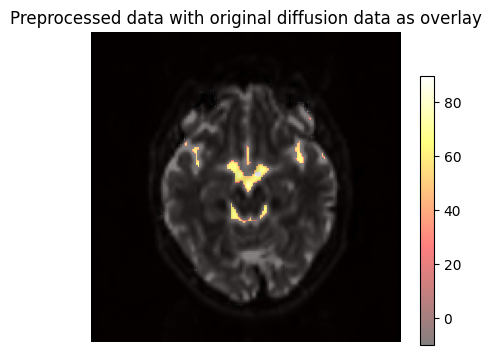

In [43]:
# File paths for both images
mif_file_path1 = 'dwi_denoised_unringed_preproc_unbiased_upsampled.mif'  
mif_file_path2 = 'masked_temperature.mif'          

# Convert both .mif files to temporary .nii.gz files with -force flag
with tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file1, \
     tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file2:
         
    # Convert main image
    result1 = subprocess.run(["mrconvert", mif_file_path1, temp_file1.name, "-force"], capture_output=True, text=True)
    if result1.returncode != 0:
        print(f"Error in mrconvert for preprocessed image: {result1.stderr}")
        exit()
    
    # Convert overlay image
    result2 = subprocess.run(["mrconvert", mif_file_path2, temp_file2.name, "-force"], capture_output=True, text=True)
    if result2.returncode != 0:
        print(f"Error in mrconvert for original image: {result2.stderr}")
        exit()
         
    # Load the converted images
    nii_image1 = nib.load(temp_file1.name)
    nii_image2 = nib.load(temp_file2.name)

    data1 = nii_image1.get_fdata()
    data2 = nii_image2.get_fdata()

    # Select middle slice 
    slice_index = data1.shape[2] // 3

    fig, axes = plt.subplots(1, 1, figsize=(5, 5))

    # Plot original diffusion data as overlay
    axes.imshow(np.rot90(data1[:, :, slice_index, 0]), cmap="Greys_r", vmin=0, vmax=1000) 
    overlay = axes.imshow(np.rot90(data2[:, :, slice_index, 0]), cmap="hot", alpha=0.5, vmin=-10, vmax=90) 
    axes.set_title("Preprocessed data with original diffusion data as overlay")
    axes.axis("off")
    fig.colorbar(overlay, ax=axes, location='right')
    plt.show()
